In [1]:
import pprint
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
client = MongoClient(host="localhost", port=27017)
db = client["air-quality"]
col = db["india"]

In [3]:
col.find_one()

{'_id': ObjectId('67f54f743fc4bf1cdcc605cf'),
 'City': 'Ahmedabad',
 'Datetime': '1/1/2015 1:00',
 'PM2': '',
 'PM10': '',
 'NO': '1',
 'NO2': '40.01',
 'NOx': '36.37',
 'NH3': '',
 'CO': '1',
 'SO2': '122.07',
 'O3': '',
 'Benzene': '0',
 'Toluene': '0',
 'Xylene': '0',
 'AQI': '',
 'AQI_Bucket': ''}

In [4]:
def wrangle(collection):
    results = collection.find({
        "City": "Mumbai"
    }, projection = {
        "Datetime": 1, "PM2": 1, "_id": 0
    })
    
    df = pd.DataFrame(results).set_index("Datetime")
    
    # Filter to only data from 2020
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.year.isin(range(2015, 2020))]
    
    # Filter to Mumbai tz
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
    
    # Convert PM2 to floating point number
    df["PM2"] = df["PM2"].astype(float)
    
    # Remove outliers
    df = df[df["PM2"] < 140]
    
    # Drop all null values
    df.dropna(inplace=True)
    

    return df

In [5]:
df = wrangle(col)
df.head()

,PM2
Datetime,
2020-01-01 05:30:00+05:30,80.90
2020-01-01 06:30:00+05:30,88.78
2020-01-01 07:30:00+05:30,117.02
2020-01-01 08:30:00+05:30,127.49
2020-01-01 09:30:00+05:30,131.77


In [6]:
y = df["PM2"].resample("1H").mean().fillna(method="ffill")
y.head()

Datetime
2020-01-01 05:00:00+05:30     80.90
2020-01-01 06:00:00+05:30     88.78
2020-01-01 07:00:00+05:30    117.02
2020-01-01 08:00:00+05:30    127.49
2020-01-01 09:00:00+05:30    131.77
Freq: H, Name: PM2, dtype: float64

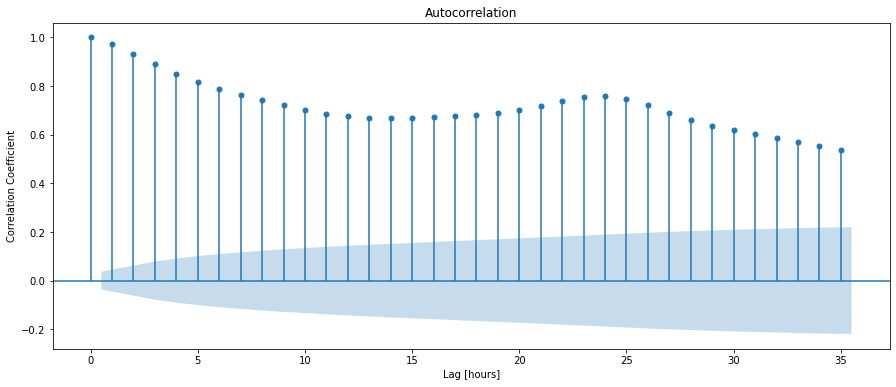

In [7]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

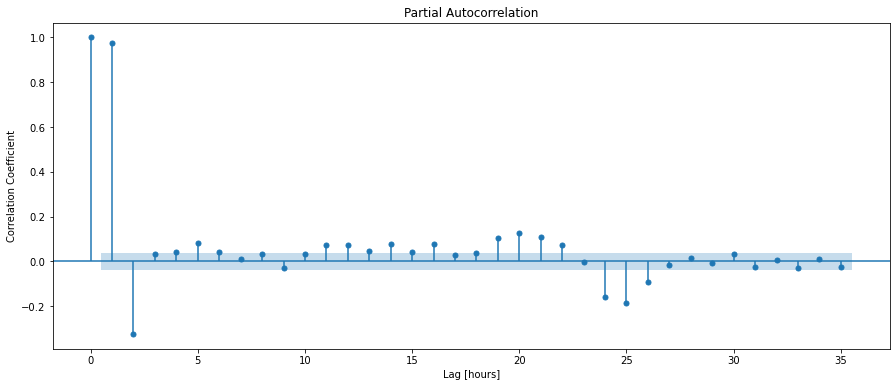

In [8]:
# plot Autocorrelation function graph
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [42]:
# train test split
cutoff = int(len(y) * 0.99)
y_train = y[:cutoff]
y_test = y[cutoff:]

In [43]:
# calculate baseline mae
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
baseline_mae

25.50956271788279

In [44]:
p_params = range(0,25,8) #auto regression
q_params = range(0,3,1) #moving average

In [45]:
mae_dict = {}
t = time.time()
for p in p_params:
    mae_dict[p] = []
    for q in q_params:
        model = ARIMA(y_train, order=(p,0,q)).fit(method_kwargs={"maxiter": 1000})
        
        y_pred = model.predict()
        model_mae = mae(y_train, y_pred)
        mae_dict[p].append(round(model_mae,4))
        print(f"ARIMA model {(p,q)} finished in {round(time.time()-t,2)} secs with mean absolute error {round(model_mae,2)}")
        
        
print(mae_dict)

ARIMA model (0, 0) finished in 0.79 secs with mean absolute error 25.51
ARIMA model (0, 1) finished in 1.52 secs with mean absolute error 13.93
ARIMA model (0, 2) finished in 2.9 secs with mean absolute error 9.27
ARIMA model (8, 0) finished in 6.88 secs with mean absolute error 4.45
ARIMA model (8, 1) finished in 13.17 secs with mean absolute error 4.45
ARIMA model (8, 2) finished in 33.69 secs with mean absolute error 4.45
ARIMA model (16, 0) finished in 44.56 secs with mean absolute error 4.42
ARIMA model (16, 1) finished in 66.41 secs with mean absolute error 4.39
ARIMA model (16, 2) finished in 124.48 secs with mean absolute error 4.3
ARIMA model (24, 0) finished in 151.53 secs with mean absolute error 4.28
ARIMA model (24, 1) finished in 205.82 secs with mean absolute error 4.22
ARIMA model (24, 2) finished in 272.1 secs with mean absolute error 4.19
{0: [25.5096, 13.9296, 9.2682], 8: [4.4549, 4.4506, 4.4519], 16: [4.4151, 4.387, 4.2996], 24: [4.2763, 4.216, 4.1928]}


In [46]:
# Visualise the mae in a datafram
pd.DataFrame(mae_dict)

,0,8,16,24
0,25.5096,4.4549,4.4151,4.2763
1,13.9296,4.4506,4.3870,4.2160
2,9.2682,4.4519,4.2996,4.1928


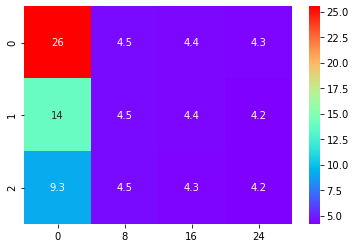

In [47]:
# heatmap of the values in mae_grid
sns.heatmap(pd.DataFrame(mae_dict), annot=True, cmap="rainbow");

In [48]:
#From above, best models are [(24,0,2) and (24,0,1)]
#Picking the one with the least smaller time used to model
order = (24,0,1)

In [63]:
model = ARIMA(y_train, order=order).fit(method_kwargs={"maxiter": 1000})

In [64]:
y_train_pred = model.predict()
train_mae = mae(y_train, y_train_pred)
train_mae

4.21600635463509

In [51]:
y_test.shape

(30,)

In [ ]:
#Predict y_test using walk forward validation
y_pred_wfv = pd.Series()
history = y_train.copy()
t = time.time()
for i in range(len(y_test)):
    model = ARIMA(history, order=order).fit(method_kwargs={"maxiter": 1000})
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[[i]])
    t -= time.time()
    


In [54]:
y_pred_wfv[:5]

2020-04-30 00:00:00+05:30    28.922212
2020-04-30 01:00:00+05:30    30.569252
2020-04-30 02:00:00+05:30    16.491672
2020-04-30 03:00:00+05:30    20.385348
2020-04-30 04:00:00+05:30    17.552292
Freq: H, dtype: float64

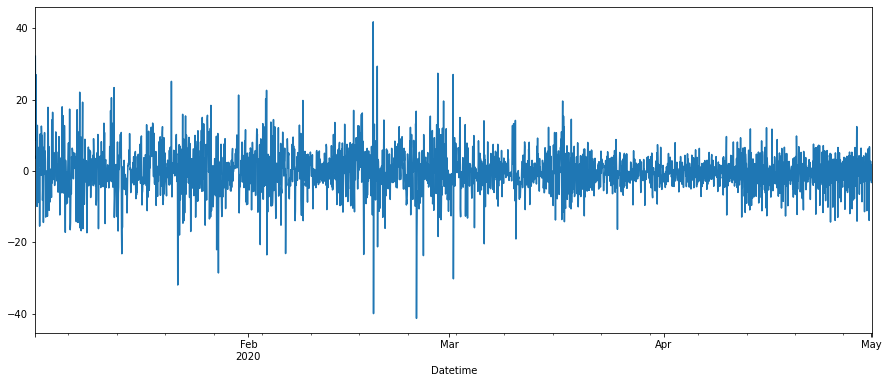

In [55]:
plt.subplots(figsize=(15,6))
model.resid.plot();

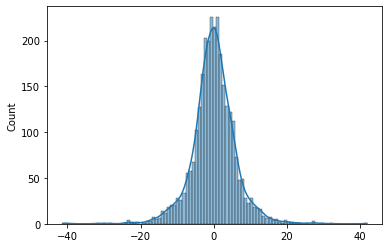

In [56]:
# Confirm most of the residuals are centered at 0 using a normal distribution
sns.histplot(model.resid, kde=True);

In [59]:
#calculate test mean absolute error
test_mae = mae(y_test, y_pred_wfv)
test_mae

3.377729482577614

In [66]:
print(f"""
Baseline Mae = {baseline_mae}
Train Mae = {train_mae}
Test Mae = {test_mae}
""")


Baseline Mae = 25.50956271788279
Train Mae = 4.21600635463509
Test Mae = 3.377729482577614



In [68]:
# put both predicted value and actual value in a dataframe
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_wfv}, index=y_test.index
)
df_pred_test.head()

,y_test,y_pred
Datetime,,
2020-04-30 00:00:00+05:30,31.02,28.922212
2020-04-30 01:00:00+05:30,19.10,30.569252
2020-04-30 02:00:00+05:30,18.78,16.491672
2020-04-30 03:00:00+05:30,17.59,20.385348
2020-04-30 04:00:00+05:30,14.91,17.552292


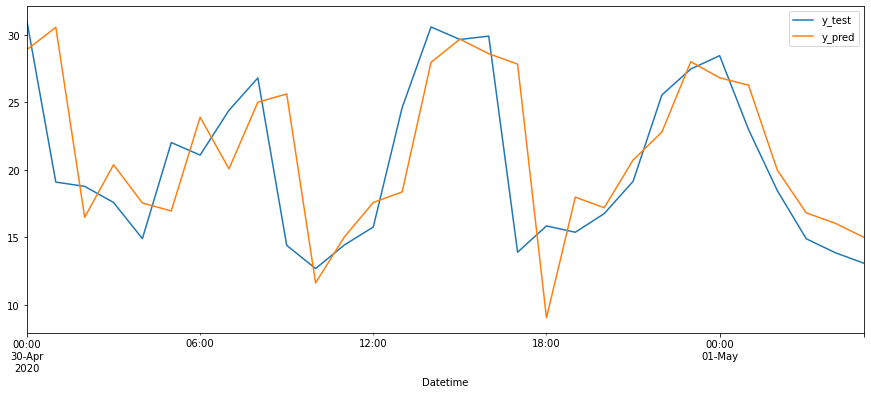

In [69]:
# time series plot for the true value and predicted value of ytest
fig, ax = plt.subplots(figsize=(15,6))
df_pred_test.plot(ax=ax);